In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
np.random.seed(0)

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import eli5

import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import csv file with data
df2015 = pd.read_csv('Zdarzenia2015.csv',delimiter=';')
df2016 = pd.read_csv('Zdarzenia2016.csv',delimiter=';')
df2017 = pd.read_csv('Zdarzenia2017.csv',delimiter=';')
df2018 = pd.read_csv('Zdarzenia2018.csv',delimiter=';')
df2019 = pd.read_csv('Zdarzenia2019.csv',delimiter=';')
df2020 = pd.read_csv('Zdarzenia2020.csv',delimiter=';')
df2021 = pd.read_csv('Zdarzenia2021.csv',delimiter=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020, df2021]).reset_index(drop=True)

In [4]:
df['Powiat'] = df['Powiat'].fillna('OTHER')
df['Gmina'] = df['Gmina'].fillna('OTHER')
df['Wojewodztwo'] = df['Wojewodztwo'].fillna('OTHER')
df['Miejscowość'] = df['Miejscowość'].fillna('OTHER')
df['Ulica'] = df['Ulica'].fillna('OTHER')
df['Numer domu'] = df['Numer domu'].fillna('OTHER')
df['KM HM (Pikietaż)'] = df['KM HM (Pikietaż)'].fillna('OTHER')
df['Numer drogi'] = df['Numer drogi'].fillna('OTHER')
df['Rondo/węzeł'] = df['Rondo/węzeł'].fillna('OTHER')
df['Skrzyżowanie z ulicą'] = df['Skrzyżowanie z ulicą'].fillna('OTHER')
df['Skrzyżowanie z drogą'] = df['Skrzyżowanie z drogą'].fillna('OTHER')
df['GPS x'] = df['GPS x'].fillna('OTHER')
df['GPS y'] = df['GPS y'].fillna('OTHER')
df['Obszar'] = df['Obszar'].fillna('OTHER')
df['Geometria drogi'] = df['Geometria drogi'].fillna('OTHER')
df['Skrzyżowanie'] = df['Skrzyżowanie'].fillna('OTHER')
df['Prędkość dopuszczalna'] = df['Prędkość dopuszczalna'].fillna('OTHER')
df['Rodzaj drogi'] = df['Rodzaj drogi'].fillna('OTHER')
df['Nawierzchnia drogi'] = df['Nawierzchnia drogi'].fillna('OTHER')
df['Stan nawierzchni'] = df['Stan nawierzchni'].fillna('OTHER')
df['Sygnalizacja świetlna'] = df['Sygnalizacja świetlna'].fillna('OTHER')
df['Oznakowanie poziome'] = df['Oznakowanie poziome'].fillna('OTHER')
df['Inne przyczyny'] = df['Inne przyczyny'].fillna('OTHER')

In [5]:
df["Data zdarzenia"] = pd.to_datetime(df["Data zdarzenia"], dayfirst=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3115047 entries, 0 to 3115046
Data columns (total 32 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   IDKSIP zdarzenia                   object        
 1   ID zdarzenia                       int64         
 2   Data zdarzenia                     datetime64[ns]
 3   Powiat                             object        
 4   Gmina                              object        
 5   Wojewodztwo                        object        
 6   Miejscowość                        object        
 7   Ulica                              object        
 8   Numer domu                         object        
 9   Numer drogi                        object        
 10  KM HM (Pikietaż)                   object        
 11  Rondo/węzeł                        object        
 12  Skrzyżowanie z ulicą               object        
 13  Skrzyżowanie z drogą               object        
 14  Od

In [7]:
df['Wypadek/Kolizja'] = pd.factorize(df['Wypadek/Kolizja'])[0]

In [8]:
def get_feats(df, black_list = ["Wypadek/Kolizja", "IDKSIP zdarzenia", "ID zdarzenia"]):
    feats = df.select_dtypes(include=[int, float]).columns
    return [x for x in feats if x not in black_list]

def feature_engineering(df):
    df['Year'] = df['Data zdarzenia'].dt.year
    df['Month'] = df['Data zdarzenia'].dt.month
    df['Week'] = df['Data zdarzenia'].dt.isocalendar().week
    df['Weekday'] = df['Data zdarzenia'].dt.weekday
    df['Day'] = df['Data zdarzenia'].dt.day
    df['Dayofyear'] = df['Data zdarzenia'].dt.dayofyear
    df['County'] = pd.factorize(df['Powiat'])[0]
    df['Community'] = pd.factorize(df['Gmina'])[0]
    df['Voivodeship'] = pd.factorize(df['Wojewodztwo'])[0]
    df['Street'] = pd.factorize(df['Ulica'])[0]
    df['House Number'] = pd.factorize(df['Numer domu'])[0]
    df['Road Number'] = pd.factorize(df['Numer drogi'])[0] 
    df['KM HM (Chainage)'] = pd.factorize(df['KM HM (Pikietaż)'])[0]
    df['Roundabout / Junction'] = pd.factorize(df['Rondo/węzeł'])[0]
    df['Intersection with the street'] = pd.factorize(df['Skrzyżowanie z ulicą'])[0]
    df['Intersection with the road'] = pd.factorize(df['Skrzyżowanie z drogą'])[0]
    df['GPS x'] = pd.factorize(df['GPS x'])[0]
    df['GPS y'] = pd.factorize(df['GPS y'])[0]
    df['Area'] = pd.factorize(df['Obszar'])[0]
    df['Geometria drogi'] = pd.factorize(df['Geometria drogi'])[0]
    df['Intersection'] = pd.factorize(df['Skrzyżowanie'])[0]
    df['Characteristics of the place of the event'] = pd.factorize(df['Charakterystyka miejsca zdarzenia'])[0]
    df['Lighting'] = pd.factorize(df['Oświetlenie'])[0]
    df['Atmospheric conditions'] = pd.factorize(df['Warunki atmosferyczne'])[0]
    df['The type of incident'] = pd.factorize(df['Rodzaj zdarzenia'])[0]
    df['Speed limit'] = pd.factorize(df['Prędkość dopuszczalna'])[0]
    df['Type of road'] = pd.factorize(df['Rodzaj drogi'])[0]
    df['Road surface'] = pd.factorize(df['Nawierzchnia drogi'])[0]
    df['The condition of the surface'] = pd.factorize(df['Stan nawierzchni'])[0]
    df['Traffic lights'] = pd.factorize(df['Sygnalizacja świetlna'])[0]
    df['Marking'] = pd.factorize(df['Oznakowanie poziome'])[0]
    df['Other reasons'] = pd.factorize(df['Inne przyczyny'])[0]
       

    return df
    
def train_and_check_model(df, model):
    df = feature_engineering(df)
    feats = get_feats(df)
        
    X = df[feats].fillna(-1).values
    y = df["Wypadek/Kolizja"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

    print(model)
    print("Features:", feats)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cf_matrix = confusion_matrix(y_test, y_pred)
    
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = ["{}\n{}\n{}".format(v1, v2, v3) for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(10, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15});
    plt.plot()
    
    print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
    print()
    print(classification_report(y_test, y_pred, target_names=["Wypadek", "Kolizja"]))
    
    return eli5.show_weights(model, feature_names=feats)

DecisionTreeClassifier(max_depth=5, random_state=0)
Features: ['Odległość do skrzyżowania', 'GPS x', 'GPS y', 'Geometria drogi', 'Year', 'Month', 'Weekday', 'Day', 'Dayofyear', 'County', 'Community', 'Voivodeship', 'Street', 'House Number', 'Road Number', 'KM HM (Chainage)', 'Roundabout / Junction', 'Intersection with the street', 'Intersection with the road', 'Area', 'Intersection', 'Characteristics of the place of the event', 'Lighting', 'Atmospheric conditions', 'The type of incident', 'Speed limit', 'Type of road', 'Road surface', 'The condition of the surface', 'Traffic lights', 'Marking', 'Other reasons']
Accuracy: 0.935861917679224

              precision    recall  f1-score   support

     Wypadek       0.59      0.13      0.21     62351
     Kolizja       0.94      0.99      0.97    872164

    accuracy                           0.94    934515
   macro avg       0.77      0.56      0.59    934515
weighted avg       0.92      0.94      0.92    934515



Weight,Feature
0.8977,The type of incident
0.0277,Characteristics of the place of the event
0.0255,GPS x
0.0132,Intersection
0.0120,Street
0.0072,Lighting
0.0062,Road Number
0.0058,The condition of the surface
0.0024,Year
0.0022,Voivodeship


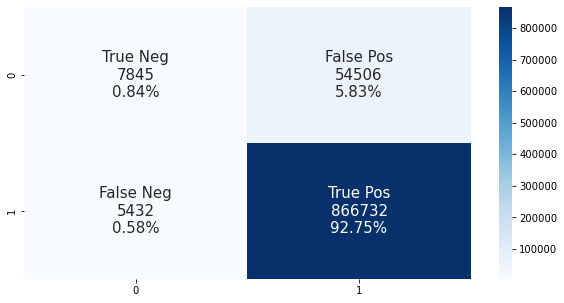

In [9]:
train_and_check_model(df, DecisionTreeClassifier(max_depth=5, random_state=0))

RandomForestClassifier(max_depth=5, random_state=0)
Features: ['Odległość do skrzyżowania', 'GPS x', 'GPS y', 'Geometria drogi', 'Year', 'Month', 'Weekday', 'Day', 'Dayofyear', 'County', 'Community', 'Voivodeship', 'Street', 'House Number', 'Road Number', 'KM HM (Chainage)', 'Roundabout / Junction', 'Intersection with the street', 'Intersection with the road', 'Area', 'Intersection', 'Characteristics of the place of the event', 'Lighting', 'Atmospheric conditions', 'The type of incident', 'Speed limit', 'Type of road', 'Road surface', 'The condition of the surface', 'Traffic lights', 'Marking', 'Other reasons']
Accuracy: 0.9332798296442539



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Wypadek       0.00      0.00      0.00     62351
     Kolizja       0.93      1.00      0.97    872164

    accuracy                           0.93    934515
   macro avg       0.47      0.50      0.48    934515
weighted avg       0.87      0.93      0.90    934515



Weight,Feature
0.3011 ± 0.4617,The type of incident
0.1991 ± 0.3415,Characteristics of the place of the event
0.0780 ± 0.1547,Other reasons
0.0550 ± 0.1401,Speed limit
0.0434 ± 0.1138,Road Number
0.0411 ± 0.1119,Street
0.0363 ± 0.1294,Intersection
0.0293 ± 0.0781,GPS y
0.0292 ± 0.0684,GPS x
0.0280 ± 0.0707,Type of road


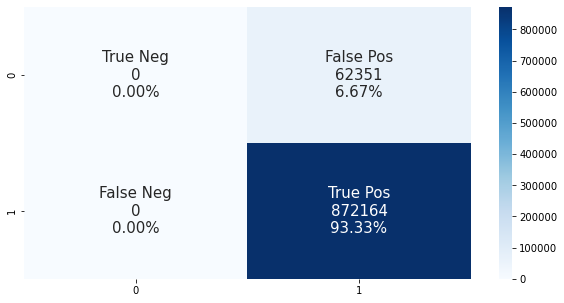

In [10]:
train_and_check_model(df, RandomForestClassifier(max_depth=5, random_state=0))

ExtraTreesClassifier(max_depth=5, random_state=0)
Features: ['Odległość do skrzyżowania', 'GPS x', 'GPS y', 'Geometria drogi', 'Year', 'Month', 'Weekday', 'Day', 'Dayofyear', 'County', 'Community', 'Voivodeship', 'Street', 'House Number', 'Road Number', 'KM HM (Chainage)', 'Roundabout / Junction', 'Intersection with the street', 'Intersection with the road', 'Area', 'Intersection', 'Characteristics of the place of the event', 'Lighting', 'Atmospheric conditions', 'The type of incident', 'Speed limit', 'Type of road', 'Road surface', 'The condition of the surface', 'Traffic lights', 'Marking', 'Other reasons']
Accuracy: 0.9332798296442539



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Wypadek       0.00      0.00      0.00     62351
     Kolizja       0.93      1.00      0.97    872164

    accuracy                           0.93    934515
   macro avg       0.47      0.50      0.48    934515
weighted avg       0.87      0.93      0.90    934515



Weight,Feature
0.2310 ± 0.4823,The type of incident
0.1511 ± 0.3318,Characteristics of the place of the event
0.0905 ± 0.2162,Intersection
0.0826 ± 0.1774,Area
0.0673 ± 0.1931,Type of road
0.0553 ± 0.1811,Other reasons
0.0537 ± 0.1336,Year
0.0310 ± 0.0980,Voivodeship
0.0274 ± 0.1472,KM HM (Chainage)
0.0266 ± 0.1203,GPS x


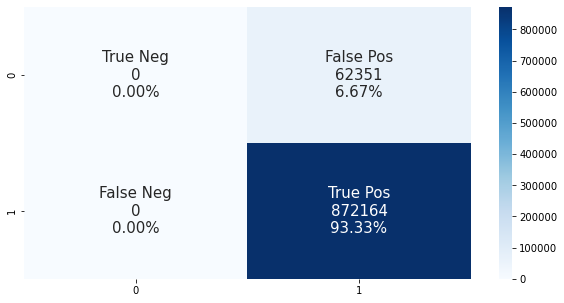

In [11]:
train_and_check_model(df, ExtraTreesClassifier(max_depth=5, random_state=0))

GradientBoostingClassifier(max_depth=5, random_state=0)
Features: ['Odległość do skrzyżowania', 'GPS x', 'GPS y', 'Geometria drogi', 'Year', 'Month', 'Weekday', 'Day', 'Dayofyear', 'County', 'Community', 'Voivodeship', 'Street', 'House Number', 'Road Number', 'KM HM (Chainage)', 'Roundabout / Junction', 'Intersection with the street', 'Intersection with the road', 'Area', 'Intersection', 'Characteristics of the place of the event', 'Lighting', 'Atmospheric conditions', 'The type of incident', 'Speed limit', 'Type of road', 'Road surface', 'The condition of the surface', 'Traffic lights', 'Marking', 'Other reasons']
Accuracy: 0.938511420362434

              precision    recall  f1-score   support

     Wypadek       0.65      0.17      0.27     62351
     Kolizja       0.94      0.99      0.97    872164

    accuracy                           0.94    934515
   macro avg       0.80      0.58      0.62    934515
weighted avg       0.92      0.94      0.92    934515



Weight,Feature
0.6959 ± 0.5380,The type of incident
0.0744 ± 0.2770,Characteristics of the place of the event
0.0318 ± 0.2628,Voivodeship
0.0295 ± 0.0881,GPS x
0.0199 ± 0.2802,County
0.0196 ± 0.1499,Other reasons
0.0179 ± 0.1121,Year
0.0167 ± 0.1207,Road Number
0.0144 ± 0.0362,Street
0.0130 ± 0.0426,Intersection


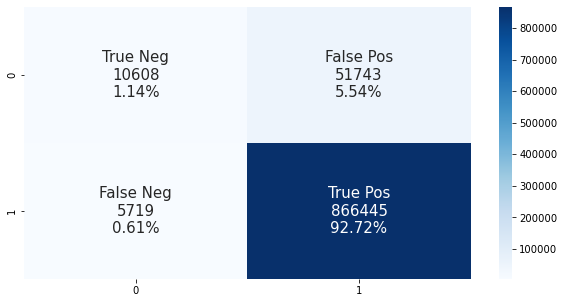

In [12]:
train_and_check_model(df, GradientBoostingClassifier(max_depth=5, random_state=0))

In [28]:
Accuracy = [0.936, 0.933, 0.933, 0.939]
Model = ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier']
df2 = pd.DataFrame({'Accuracy': Accuracy, 'Model': Model
                   })

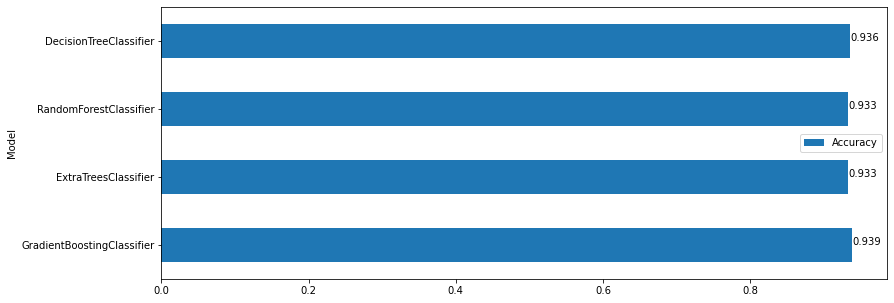

In [29]:
df2 = df2.sort_index(ascending=False)
ax = df2.plot.barh(x='Model', y='Accuracy', rot=0,figsize=(13,5))
y = df2['Accuracy']
for index, value in enumerate(y):
    plt.text(value, index, str(value))